# Python for Finance, Part 3: Moving Average Trading Strategy

In the previous article of this series, we continued to discuss general concepts whicch are fundamental to the design and backtesting of any [quantitative trading strategy](http://www.learndatasci.com/python-finance-part-2-intro-quantitative-trading-strategies/). In detail, we have discussed about 

1. relative and log-returns, their properties, differences and how to use each one,
2. a generic representation of a trading strategy using the normalised asset weights $w_i\left(t\right)$ for a set of $N$ 
   tradable assets and 
3. a very simple, yet profitable strategy, the way to represent it and how to calculate its total return.

If you just found this article, see [Part 1](http://www.learndatasci.com/python-finance-part-yahoo-finance-api-pandas-matplotlib/) and [Part 2](http://www.learndatasci.com/python-finance-part-2-intro-quantitative-trading-strategies/).

In this article, we will start designing a more complex trading strategy, which will have non-constant weights $w_i\left(t\right)$, and thus adapt in some way to the recent behaviour of the price of our assets. 

We will again assume we have a universe of just 3 tradable assets, the Apple and Microsoft stocks (with tickers **AAPL** and **MSFT** respectively) and the S&P 500 Index (ticker **^GSPC**).

As a reminder, the dataframe containing the three "cleaned" price timeseries has the following format:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

%matplotlib inline
my_year_month_fmt = mdates.DateFormatter('%m/%y')

data = pd.read_pickle('./data.pkl')
data.head(10)

,AAPL,MSFT,^GSPC
2000-01-03,3.625643,39.334630,1455.219971
2000-01-04,3.319964,38.005900,1399.420044
2000-01-05,3.368548,38.406628,1402.109985
2000-01-06,3.077039,37.120080,1403.449951
2000-01-07,3.222794,37.605172,1441.469971
2000-01-10,3.166112,37.879354,1457.599976
2000-01-11,3.004162,36.909170,1438.560059
2000-01-12,2.823993,35.706986,1432.250000
2000-01-13,3.133722,36.381897,1449.680054
2000-01-14,3.253159,37.879354,1465.150024


## Moving Average Considerations

One of the oldest and simplest trading strategies that exist is the one that uses a moving average of the price (or returns) timeseries to proxy the recent trend of the price. 

The idea is quite simple, yet powerful; if we use a (say) 100-day moving average of our price time-series, then a significant portion of the daily price noise will have been "averaged-out". Thus, we can can observe more closely the longer-term behaviour of the asset. 

Let us, again, calculate the rolling *simple moving averages (SMA)* of these three timeseries as follows. Remember, again, that when calculating the $M$ days SMA, the first $M-1$ are not valid, as $M$ prices are required for the first moving average data point.

In [3]:
# Calculating the short-window simple moving average
short_rolling = data.rolling(window=20).mean()
short_rolling.head(20)

,AAPL,MSFT,^GSPC
2000-01-03,NaN,NaN,NaN
2000-01-04,NaN,NaN,NaN
2000-01-05,NaN,NaN,NaN
2000-01-06,NaN,NaN,NaN
2000-01-07,NaN,NaN,NaN
2000-01-10,NaN,NaN,NaN
2000-01-11,NaN,NaN,NaN
2000-01-12,NaN,NaN,NaN
2000-01-13,NaN,NaN,NaN
2000-01-14,NaN,NaN,NaN


In [4]:
# Calculating the long-window simple moving average
long_rolling = data.rolling(window=100).mean()
long_rolling.tail()

,AAPL,MSFT,^GSPC
2016-12-26,110.958205,58.418182,2176.628791
2016-12-27,111.047874,58.476117,2177.500190
2016-12-28,111.140589,58.532936,2178.244490
2016-12-29,111.233698,58.586112,2178.879189
2016-12-30,111.315270,58.635267,2179.426990


Let us plot the last $2$ years for these three timeseries for Microsoft stock, to get a feeling about how these behave.

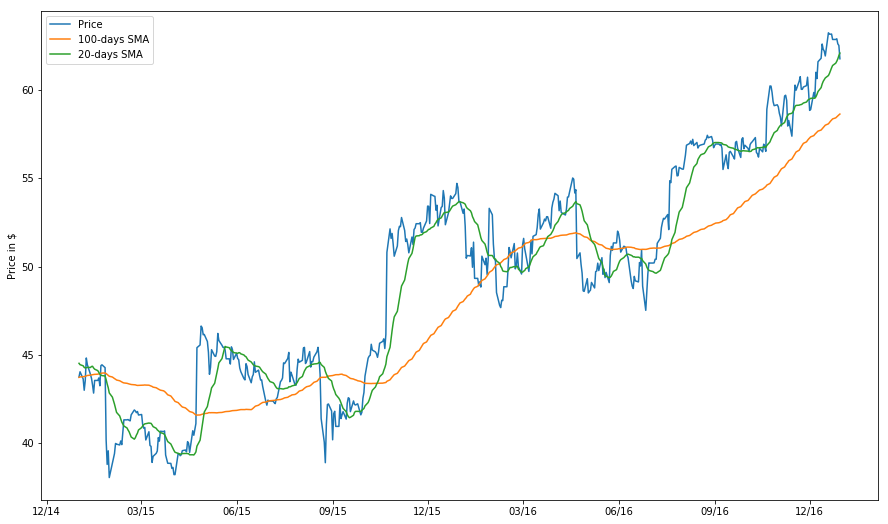

In [5]:
start_date = '2015-01-01'
end_date = '2016-12-31'

fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(1,1,1)

ax.plot(data.ix[start_date:end_date, :].index, data.ix[start_date:end_date, 'MSFT'], label='Price')
ax.plot(long_rolling.ix[start_date:end_date, :].index, long_rolling.ix[start_date:end_date, 'MSFT'], label = '100-days SMA')
ax.plot(short_rolling.ix[start_date:end_date, :].index, short_rolling.ix[start_date:end_date, 'MSFT'], label = '20-days SMA')

ax.legend(loc='best')
ax.set_ylabel('Price in $')
ax.xaxis.set_major_formatter(my_year_month_fmt)

It is straightforward to observe that SMA timeseries are much less noisy than the original price timeseries. However, this comes at a cost: SMA timeseries lag the original price timeseries, which means that changes in the trend are only seen with a delay (lag) of $L$ days. 

How much is this lag $L$? For a SMA moving average calculated using $M$ days, the lag is roughly $\frac{M}{2}$ days. Thus, if we are using a $100$ days SMA, this means we may be late by almost $50$ days, which can significantly affect our strategy.

One way to reduce the lag induced by the use of the SMA is to use the so-called Exponential Moving Average (EMA), defined as

\begin{equation}
\begin{split}
& \text{EMA}\left(t\right) & = \left(1-\alpha\right)\text{EMA}\left(t-1\right) + \alpha \ p\left(t\right) \\ & \text{EMA}\left(t_0\right) & = p\left(t_0\right)
\end{split}
\end{equation}

where $p\left(t\right)$ is the price at time $t$ and $\alpha$ is called the decay parameter for the EMA. $\alpha$ is related to the lag as $$ \alpha = \frac{1}{L + 1}$$ and the length of the window (span) $M$ as $$ \alpha = \frac{2}{M + 1}$$.

The reason why EMA reduces the lag is that it puts more weight on more recent observations, whereas the SMA weights all observations equally by $\frac{1}{M}$. Using Pandas, calculating the exponential moving average is easy. We need to provide a lag value, from which the decay parameter $\alpha$ is automatically calculated. To be able to compare with the short-time SMA we will use a span value of $20$.

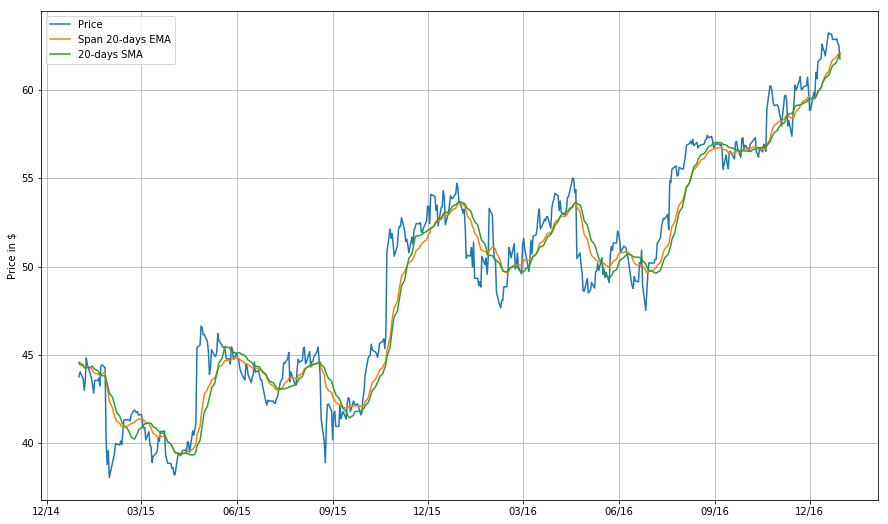

In [6]:
# Using Pandas to calculate a 20-days span EMA. adjust=False specifies that we are interested in the recursive calculation mode.
ema_short = data.ewm(span=20, adjust=False).mean()

fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(1,1,1)

ax.plot(data.ix[start_date:end_date, :].index, data.ix[start_date:end_date, 'MSFT'], label='Price')
ax.plot(ema_short.ix[start_date:end_date, :].index, ema_short.ix[start_date:end_date, 'MSFT'], label = 'Span 20-days EMA')
ax.plot(short_rolling.ix[start_date:end_date, :].index, short_rolling.ix[start_date:end_date, 'MSFT'], label = '20-days SMA')

ax.legend(loc='best')
ax.set_ylabel('Price in $')
ax.grid()
ax.xaxis.set_major_formatter(my_year_month_fmt)

## A Moving Average Trading Strategy

Let us attempt to use the moving averages calculated above to design a trading strategy. Our first attempt is going to be relatively straghtforward and is going to take advantage of the fact that a moving average timeseries (whether SMA or EMA) lags the actual price behaviour. 

Bearing this in mind, it is natural to assume that when a change in the long term behaviour of the asset occurs, the actual price timeseries will react faster than the EMA one. Therefore, we will consider the crossing of the two as potential trading signals. 

1. When the price timeseries $p\left(t\right)$ crosses the EMA timeseries $e\left(t\right)$ from below, we will close any existing short position and go long (buy) one unit of the asset. 

2. When the price timeseries $p\left(t\right)$ crosses the EMA timeseries $e\left(t\right)$ from above, we will close any existing long position and go short (sell) one unit of the asset. 

<img src="http://www.learndatasci.com/wp-content/uploads/2017/07/Moving-Average-Price-Crossover-Illustration.png" />

How is this translated to the framework described in our previous article about the weights $w\left(t\right)$? 

Well for this strategy it is pretty straghtforward. All we need is to have a long position, i.e. $w_i\left(t\right)$ >0, as long as the price timeseries is above the EMA timeseries and a short position, i.e. $w_i\left(t\right)$ < 0, as long as the price timeseries is below the EMA timeseries. 

Since, at this point, we are not interested yet in position sizing, we will assume that we use all our funds available to trade asset $i$. We will also assume that our funds are split equally across all $3$ assets (MSFT, AAPL and ^GSPC).

Based on these assumptions, our strategy for each of the assets $i, i = 1, \ldots, 3$ can be translated as follows:

+ Go long condition:     If $p_i\left(t\right) > e_i\left(t\right)$, then $w_i\left(t\right) = \frac{1}{3}$
+ Go short condition:    If $p_i\left(t\right) < e_i\left(t\right)$, then $w_i\left(t\right) = -\frac{1}{3}$

Whenever, the trade conditions are satisfied, the weights are $\frac{1}{3}$ because $\frac{1}{3}$ of the total funds are assigned to each asset and whenever we are long or short, all of the available funds are invested.

How is this implemented in Python? The trick is to take the sign of the difference between then price $p_i\left(t\right)$ and the EMA $e_i\left(t\right)$.

In [31]:
# Taking the difference between the prices and the EMA timeseries
trading_positions_raw = data - ema_short
trading_positions_raw.tail()

,AAPL,MSFT,^GSPC
2016-12-26,2.039488,1.040200,20.465712
2016-12-27,2.511890,0.977103,23.121693
2016-12-28,1.822235,0.623249,3.765377
2016-12-29,1.621664,0.482954,2.809706
2016-12-30,0.647437,-0.246519,-6.894490


In [32]:
# Taking the sign of the difference to determine whether the price or the EMA is greater and then multiplying by 1/3
trading_positions = trading_positions_raw.apply(np.sign) * 1/3
trading_positions.tail()

,AAPL,MSFT,^GSPC
2016-12-26,0.333333,0.333333,0.333333
2016-12-27,0.333333,0.333333,0.333333
2016-12-28,0.333333,0.333333,0.333333
2016-12-29,0.333333,0.333333,0.333333
2016-12-30,0.333333,-0.333333,-0.333333


### One Final Caveat
Before seeing the performance of this strategy, let us focus on the first day $t_o$ when the price timeseries $p\left(t_o\right)$ crosses above and EMA timeseries $e_i\left(t_o\right)$. Since $p\left(t_o\right) > e_i\left(t_o\right)$. At that point the trading weight $w_i\left(t_o\right)$ becomes positive, and thus according to our trading strategy, we need to set for that day $w_i\left(t_o\right)=\frac{1}{3}$. 

However, bear in mind that $p\left(t_o\right)$ is the price of the asset at the close of day $t_o$. For this reason, we will not know that $p\left(t_o\right) > e_i\left(t_o\right)$ until the close of the trading day. Therefore, when calculating the returns of the strategy, to assume that on day $t_o$ we had a long position is an error; it is equivalent to us peaking into the future, since we only know we have to go long at the end of day $t_o$. 

The best we can do is assume that we traded at the close of this day $t_o$. Therefore our position will be long starting on the following day, $t_o + 1$. This is easily corrected for by lagging our trading positions by one day, so that on day $t_o$ our actual position is that of the previous day $t_o - 1$ and only on day $t_o + 1$ do we have a long position. Thus:

In [33]:
# Lagging our trading signals by one day.
trading_positions_final = trading_positions.shift(1)

Let us examine what the timeseries and the respective trading position look like for one of our assets, Microsoft.

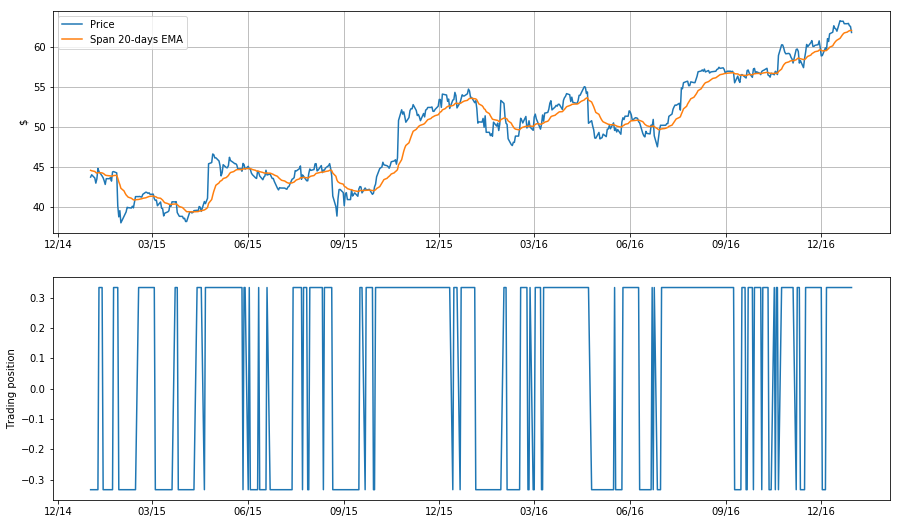

In [34]:
fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(2,1,1)

ax.plot(data.ix[start_date:end_date, :].index, data.ix[start_date:end_date, 'MSFT'], label='Price')
ax.plot(ema_short.ix[start_date:end_date, :].index, ema_short.ix[start_date:end_date, 'MSFT'], label = 'Span 20-days EMA')

ax.set_ylabel('$')
ax.legend(loc='best')
ax.grid()
ax.xaxis.set_major_formatter(my_year_month_fmt)

ax = fig.add_subplot(2,1,2)

ax.plot(trading_positions_final.ix[start_date:end_date, :].index, trading_positions_final.ix[start_date:end_date, 'MSFT'], 
        label='Trading position')

ax.set_ylabel('Trading position')
ax.xaxis.set_major_formatter(my_year_month_fmt)

Now that the position our strategy dictates each day has been calculated, the performance of this strategy can be easily estimated. To that end, we will need again the log-returns of the three assets $r_i\left(t\right)$. These are calculated as: 

In [35]:
# Log returns - First the logarithm of the prices is taken and the the difference of consecutive (log) observations
asset_log_returns = np.log(data).diff()
asset_log_returns.head()

,AAPL,MSFT,^GSPC
2000-01-03,NaN,NaN,NaN
2000-01-04,-0.088078,-0.034364,-0.039099
2000-01-05,0.014528,0.010489,0.001920
2000-01-06,-0.090514,-0.034072,0.000955
2000-01-07,0.046281,0.012984,0.026730


Note that our strategy trades each asset separately and is agnostic of what the behaviour of the other assets is. Whether we are going to be long or short (and how much) in MSFT is in no way affected by the other two assets. With this in mind, the daily log-returns of the strategy for each asset $i$, $r_{i}^s\left(t\right)$ are calculated as

\begin{equation}
r_{i}^s\left(t\right) = w_i\left(t\right) r_i\left(t\right)
\end{equation}

where $w_i\left(t\right)$ is the strategy position on day $t$ which has already been attained at the end of trading day $t-1$. 

What does this mean? 

Assume that $p\left(t\right)$ crosses above $e_i\left(t\right)$ sometime during the trading session on Monday, day $t-1$. We assume that at the close on Monday we buy enough units of asset $i$ to spend $\frac{1}{3}$ of our total funds, that is $\$\frac{N}{3}$ and that the price we bought at is $p\left(t-1\right) = \$10$. Let us also assume that on Tuesday, day $t$, the price closes at $p\left(t\right) = \$10.5$.  Then our log-return for asset $i$ on Tuesday,  is simply 

$$ \frac{1}{3} \times \log \left(\frac{$10.5}{\$10} \right) \simeq \frac{0.049}{3}$$

The actual return $r_{\text{rel}, i}^s\left(t\right)$ is 

\begin{equation}
r_{\text{rel}, i}^s\left(t\right) = w_i\left(t\right) \times \left[\exp \left(r_i\left(t\right)\right) - 1 \right] = \frac{0.05}{3}
\end{equation}

In terms of dollars, on Tuesday, day $t$, we made $N \times r_{\text{rel}, i}^s\left(t\right) = \$ \frac{0.05N}{3}$.

To get all the strategy log-returns for all days, one needs simply to multiply the strategy positions with the asset log-returns. 

In [36]:
strategy_asset_log_returns = trading_positions_final * asset_log_returns
strategy_asset_log_returns.tail()  

,AAPL,MSFT,^GSPC
2016-12-26,0.000000,0.000000,0.000000
2016-12-27,0.002110,0.000211,0.000749
2016-12-28,-0.001424,-0.001531,-0.002797
2016-12-29,-0.000086,-0.000477,-0.000098
2016-12-30,-0.002609,-0.004052,-0.001549


Remembering that the log-returns can be added to show performance across time, let us plot the cumulative log-returns and the cumulative total relative returns of our strategy for each of the assets.

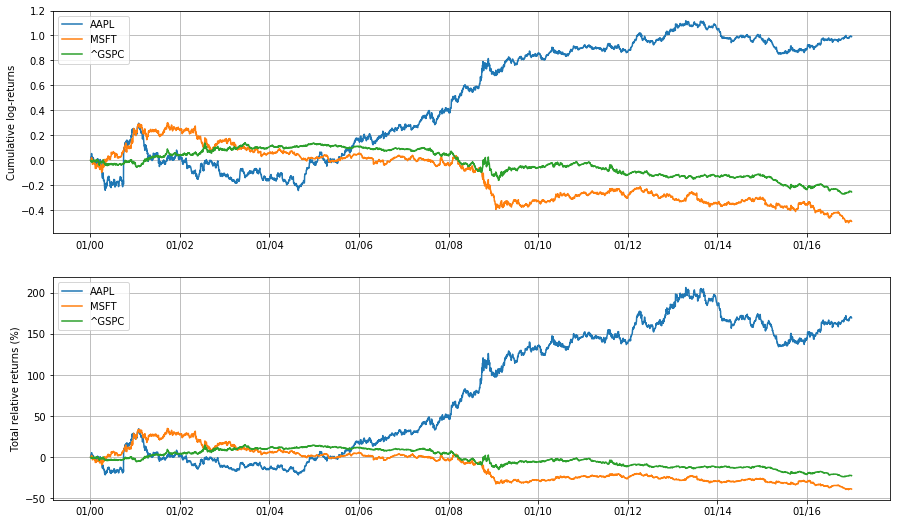

In [38]:
# Get the cumulative log-returns per asset
cum_strategy_asset_log_returns = strategy_asset_log_returns.cumsum()

# Transform the cumulative log returns to relative returns
cum_strategy_asset_relative_returns = np.exp(cum_strategy_asset_log_returns) - 1

fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(2,1,1)

for c in asset_log_returns:
    ax.plot(cum_strategy_asset_log_returns.index, cum_strategy_asset_log_returns[c], label=str(c))

ax.set_ylabel('Cumulative log-returns')
ax.legend(loc='best')
ax.xaxis.set_major_formatter(my_year_month_fmt)
ax.grid()

ax = fig.add_subplot(2,1,2)

for c in asset_log_returns:
    ax.plot(cum_strategy_asset_relative_returns.index, 100*cum_strategy_asset_relative_returns[c], label=str(c))

ax.set_ylabel('Total relative returns (%)')
ax.legend(loc='best')
ax.grid()
ax.xaxis.set_major_formatter(my_year_month_fmt)

## What is the Total Return of the Strategy? 

Strictly speaking, we can only add relative returns to calculate the strategy returns. Therefore $$ r_{\text{rel}}^s\left(t\right) = \sum_{i=1}^{3}r_{\text{rel}, i}^s\left(t\right)$$.

We saw in the previous article, however, that for small values of the relative returns, the following approximation holds $$ r_i\left(t\right) \simeq r_{\text{rel},i}\left(t\right)$$

Thus, an alternative way is to simply add all the strategy log-returns first and then convert these to relative returns. Let us examine how good this approximation is.

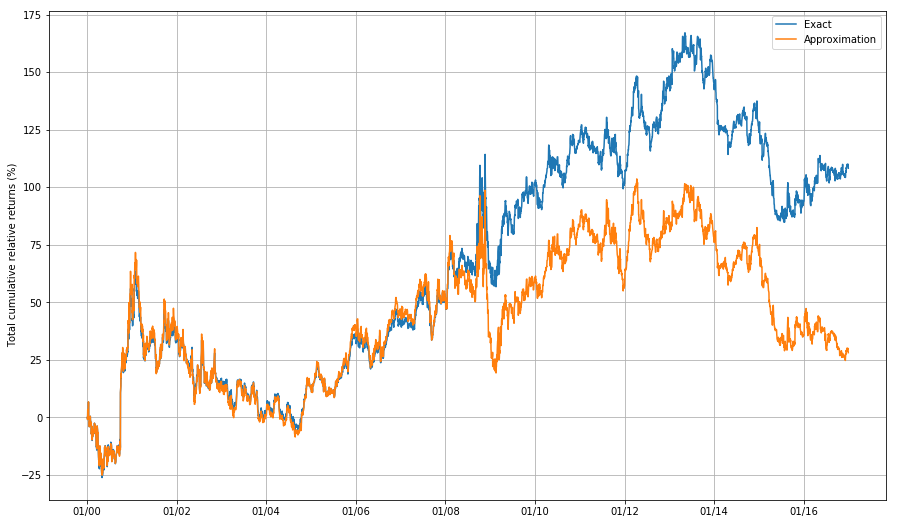

In [40]:
# Total strategy relative returns. This is the exact calculation.
cum_relative_return_exact = cum_strategy_asset_relative_returns.sum(axis=1)

# Get the cumulative log-returns per asset
cum_strategy_log_return = cum_strategy_asset_log_returns.sum(axis=1)

# Transform the cumulative log returns to relative returns. This is the approximation
cum_relative_return_approx = np.exp(cum_strategy_log_return) - 1

fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(1,1,1)

ax.plot(cum_relative_return_exact.index, 100*cum_relative_return_exact, label='Exact')
ax.plot(cum_relative_return_approx.index, 100*cum_relative_return_approx, label='Approximation')

ax.set_ylabel('Total cumulative relative returns (%)')
ax.legend(loc='best')
ax.grid()
ax.xaxis.set_major_formatter(my_year_month_fmt)

As we can see, for relatively small time-intervals and as long the assumption that relative returns are small enough, the calculation of the total strategy returns using the log-return approximation can be satisfactory. However, when the small scale assumption breaks down, then the approximation is poor. Therefore what we need to remember the following:

1. Log-returns can and should be added across time for a single asset to calculate cumulative return timeseries across time.
2. However, when summing (or averaging) log-returns across assets, care should be taken. Relative returns can be added, but log-returns only if we can safely assume they are a good-enough approximation of the relative returns.

The overall, yearly, performance of our strategy can be calculated again as:

In [41]:
def print_portfolio_yearly_statistics(portfolio_cumulative_relative_returns, days_per_year = 52 * 5):

    total_days_in_simulation = portfolio_cumulative_relative_returns.shape[0]
    number_of_years = total_days_in_simulation / days_per_year

    # The last data point will give us the total portfolio return
    total_portfolio_return = portfolio_cumulative_relative_returns[-1]
    # Average portfolio return assuming compunding of returns
    average_yearly_return = (1 + total_portfolio_return)**(1/number_of_years) - 1

    print('Total portfolio return is: ' + '{:5.2f}'.format(100*total_portfolio_return) + '%')
    print('Average yearly return is: ' + '{:5.2f}'.format(100*average_yearly_return) + '%')

print_portfolio_yearly_statistics(cum_relative_return_exact)

Total portfolio return is: 108.24%
Average yearly return is:  4.39%


# What Next?

One can observe that this strategy signficantly underperforms the buy and hold strategy that was presented in the previous article. Let's compare them again:

Total portfolio return is: 248.51%
Average yearly return is:  7.59%


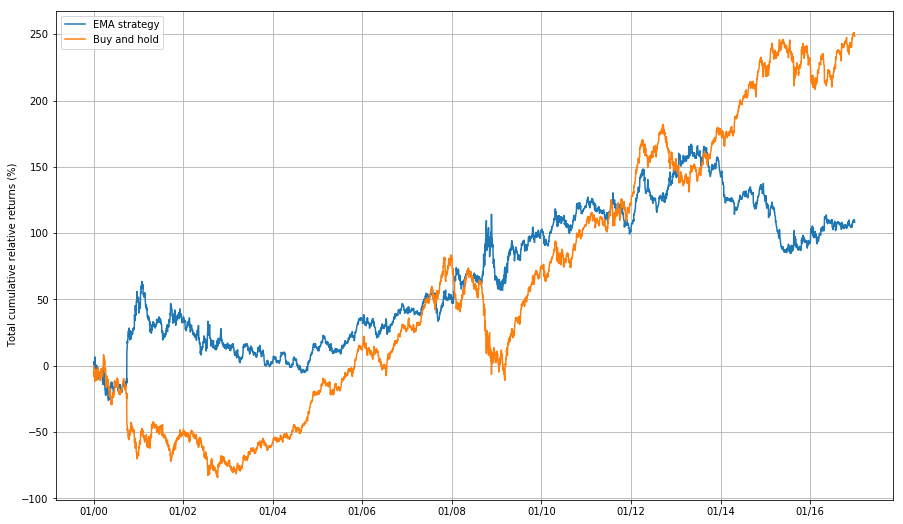

In [42]:
# Define the weights matrix for the simple buy-and-hold strategy
simple_weights_matrix = pd.DataFrame(1/3, index = data.index, columns=data.columns)

# Get the buy-and-hold strategy log returns per asset
simple_strategy_asset_log_returns = simple_weights_matrix * asset_log_returns

# Get the cumulative log-returns per asset
simple_cum_strategy_asset_log_returns = simple_strategy_asset_log_returns.cumsum()

# Transform the cumulative log returns to relative returns
simple_cum_strategy_asset_relative_returns = np.exp(simple_cum_strategy_asset_log_returns) - 1

# Total strategy relative returns. This is the exact calculation.
simple_cum_relative_return_exact = simple_cum_strategy_asset_relative_returns.sum(axis=1)

fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(1,1,1)

ax.plot(cum_relative_return_exact.index, 100*cum_relative_return_exact, label='EMA strategy')
ax.plot(simple_cum_relative_return_exact.index, 100*simple_cum_relative_return_exact, label='Buy and hold')

ax.set_ylabel('Total cumulative relative returns (%)')
ax.legend(loc='best')
ax.grid()
ax.xaxis.set_major_formatter(my_year_month_fmt)

print_portfolio_yearly_statistics(simple_cum_relative_return_exact)

### Which Strategy is Better? 
This is not a simple question for one to answer at this point. When we need to choose between two or more strategies, we need to define a metric (or metrics) based on which to compare them. This very important topic will be covered in the next article. 

In addition, we observe in this last graph that the performance of the two strategies is not constant across time. There are some periods when one outperforms the other and other periods when it is not. So a second question that naturally arises is how do we mitigate the risk to be "tricked" by a good backtesting performance in a given period.